# Projet 4 : Anticipez les besoins en consommation électrique de bâtiments

L'objectif est double :
- Prédire les émissions de Co2 et la consommation totale d'énergie des bâtiments pour lesquels elles n'ont pas été mesurées 

- Evaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions


Les données des bâtiments sont disponibles à  cette adresse : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv


Démarche : 

1/ Pré-traitement des données
- Concaténer les données de 2015 et 2016
- Nettoyage des données
- Séléction des variables importantes
- Analyse des données
- Préparation des données
- Sélection et entrainment de modèles

2/ L'énergie totale est prédite à partir des caractéristiques des bâtiments

3/ La proportion de chaque source d'énergie (électricité, gas...) est déterminé, à partir des mêmes variables que pour la prédiction de la consommation d'énergie totale

4/ Les émissions de Co2 sont ensuite prédites à partir des prédictions de la proportion de chaque source, de l'énergie totale prédite et des caractèristiques des bâtiments

L'Energy Star Score est un score entre 1 et 100 qui reflète l'efficacité énergétique d'un bâtiment parmi les bâtiments similaires déjà certifiés. Un score de 50 signifie qu'il est dans la médiane alors qu'un score au dessus de 75 indique qu'il s'agit d'un bâtiment à haute performance

Des informations complémentaires sur le calcul de l'Energy Star Score sont dispononibles ici :https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/how-1-100

#### Chargement des librairies

In [5]:
# Librairies communes pour le ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Séparateur de jeu de données
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

# Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.base import clone

# Métrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.utils import check_array

# Cross validation 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Création de pipelines
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

# Transformateurs de variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from sklearn.feature_extraction import FeatureHasher

C:\Users\maleg\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\maleg\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\maleg\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\maleg\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


#### Lecture des données

In [6]:
# Chemin d'accès aux données
path = "D:/OpenClassRoom/Projet_4/data"
# Lecture des données
data_2015 = pd.read_csv(os.path.join(path, "2015-building-energy-benchmarking.csv"), sep=",")
data_2016 = pd.read_csv(os.path.join(path, "2016-building-energy-benchmarking.csv"), sep=",")

Il y a un relévé de consommation pour l'année 2015 et un autre pour l'année 2016

## 1. Description des données

### 1.1 Affichage des données

In [7]:
print("Il y a {} batiments différents pour le relevé 2015".format(data_2015["OSEBuildingID"].nunique()))
# Affichage des 5 premières lignes des données 2015
data_2015.head(3)

Il y a 3340 batiments différents pour le relevé 2015


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'needs_recoding': ...",7,DOWNTOWN,1927,...,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'needs_recoding': ...",7,DOWNTOWN,1996,...,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'needs_recoding': ...",7,DOWNTOWN,1969,...,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN


In [8]:
print("Il y a {} batiments différents pour le relevé 2016".format(data_2016["OSEBuildingID"].nunique()))
# Affichage des 3 premières lignes des données 2016
data_2016.head()

Il y a 3376 batiments différents pour le relevé 2016


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


### 1.2 Structure des données

In [9]:
# Structure : entrées, colonnes, types et valeurs non nulles
data_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 42 columns):
OSEBuildingID                        3340 non-null int64
DataYear                             3340 non-null int64
BuildingType                         3340 non-null object
PrimaryPropertyType                  3340 non-null object
PropertyName                         3340 non-null object
TaxParcelIdentificationNumber        3338 non-null object
Location                             3340 non-null object
CouncilDistrictCode                  3340 non-null int64
Neighborhood                         3340 non-null object
YearBuilt                            3340 non-null int64
NumberofBuildings                    3340 non-null int64
NumberofFloors                       3332 non-null float64
PropertyGFATotal                     3340 non-null int64
PropertyGFAParking                   3340 non-null int64
PropertyGFABuilding(s)               3340 non-null int64
ListOfAllPropertyUseTypes     

In [10]:
# Structure : entrées, colonnes, types et valeurs non nulles
data_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
OSEBuildingID                      3376 non-null int64
DataYear                           3376 non-null int64
BuildingType                       3376 non-null object
PrimaryPropertyType                3376 non-null object
PropertyName                       3376 non-null object
Address                            3376 non-null object
City                               3376 non-null object
State                              3376 non-null object
ZipCode                            3360 non-null float64
TaxParcelIdentificationNumber      3376 non-null object
CouncilDistrictCode                3376 non-null int64
Neighborhood                       3376 non-null object
Latitude                           3376 non-null float64
Longitude                          3376 non-null float64
YearBuilt                          3376 non-null int64
NumberofBuildings                  3368 non-null float

### 1.3 Concaténation des données

Il y a 2 relevés de données pour les bâtiments étudiés (2015 et 2016), dans cette partie il s'agit de concaténer les données en détectant les doublons et en assurant la conrrespondance des colonnes

#### Affichage des colonnes non communes aux deux années

In [11]:
[col for col in data_2015 if col not in data_2016]

['Location',
 'OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment']

#### On assure l'unicité des bâtiments dans les deux relévés via la colonne OSEBuildingID

In [12]:
# On récupère les données batiments 2016 dont les OSEBuildingID ne sont pas das les données 2015
OSEBuildingID = [OSEBuildingID for OSEBuildingID in data_2015["OSEBuildingID"] if OSEBuildingID not in data_2016["OSEBuildingID"].values]
#data_2016 = data_2016[data_2016["OSEBuildingID"].isin(OSEBuildingID)]
print("Il y a pour le relevé 2015 : {} bâtiments non existants dans le relevé 2016".format(len(OSEBuildingID)))

Il y a pour le relevé 2015 : 56 bâtiments non existants dans le relevé 2016


Il s'agit de la même ville donc les 2 relevés contiennent logiquement une majorité de bâtiments communs 

#### Renommage de certaines colonnes

In [13]:
# On renomme les colonnes de 2015 pour que les noms des variables soient les mêmes que pour 2016 (Energy et CO2)
data_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)' : 'TotalGHGEmissions', 'GHGEmissionsIntensity(kgCO2e/ft2)' : 'GHGEmissionsIntensity'}, inplace=True)

Les colonnes 'GHGEmissions(MetricTonsCO2e)' et 'GHGEmissionsIntensity(kgCO2e/ft2)' du relevé 2015 sont renommés pour les faire correspondre aux noms des colonnes du relevé 2016

#### Longitude et Latitude dans les données 2015

In [14]:
# On intégre la latitude et la longitude du batiment, obtenus à partir de la colonne 'Location'
latitudes = []
longitudes = []
for loc in data_2015["Location"]:
    latitudes.append(float(loc.split(":")[1].split("'")[1]))
    longitudes.append(float(loc.split(':')[8].split("'")[1]))

data_2015.drop(columns=['Location'], inplace=True)
data_2015["Longitude"] = longitudes
data_2015["Latitude"] = latitudes

#### Traitement des colonnes non communes

In [15]:
# On supprime Comment
data_2015.drop(columns=['Comment'] , inplace=True)

In [16]:
# On rajoute OtherFuel Comment
data_2016["OtherFuelUse(kBtu)"] = 0
# Les valeurs manquantes de la colonne "OtherFuelUse(kBtu)" sont remplacés par des 0
data_2015["OtherFuelUse(kBtu)"].fillna(0, inplace=True)

In [17]:
# On supprime les dernières colonnes qui ne sont pas communes aux 2 DataFrame
drop_col = [col for col in data_2016 if col not in data_2015]
data_2016.drop(columns=drop_col, inplace=True)

#### Concaténation données 2015 et 2016

In [18]:
# On assemble les données de 2015 et 2016
data = pd.concat([data_2015, data_2016])

C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [19]:
# On regorupe les données de bâtiments communs, en moyennant les valeurs
data = data.groupby(["OSEBuildingID"]).agg("mean")

In [20]:
cat_attribs = list(data_2015.drop(columns=list(data.columns) + ["OSEBuildingID"]).columns)

In [21]:
data[cat_attribs] = data_2016.set_index("OSEBuildingID")[cat_attribs]

OSEBuildingID_2015 = [ID for ID in data_2015["OSEBuildingID"] if ID not in data_2016["OSEBuildingID"].values]
data[cat_attribs] = data_2016.set_index("OSEBuildingID")[cat_attribs]
data.loc[OSEBuildingID_2015, cat_attribs] = data_2015.set_index("OSEBuildingID").loc[OSEBuildingID_2015, cat_attribs]

In [22]:
print("Le nombre de bâtiments uniques est de : {}".format(len(data)))

Le nombre de bâtiments uniques est de : 3432


### 1.4 Variables catégorielles et numériques

#### Variables catégorielles

In [23]:
# Les colonnes object dtypes sont séléctionnés
obj_columns = list(data.select_dtypes(include='object').columns)

In [24]:
print("Les variables catégorielles sont les suivantes : \n")
for categ in obj_columns :
    print(categ)

Les variables catégorielles sont les suivantes : 

BuildingType
PrimaryPropertyType
PropertyName
TaxParcelIdentificationNumber
Neighborhood
ListOfAllPropertyUseTypes
LargestPropertyUseType
SecondLargestPropertyUseType
ThirdLargestPropertyUseType
YearsENERGYSTARCertified
DefaultData
ComplianceStatus
Outlier


#### Variables numériques

In [25]:
# Les colonnes float64 sont séléctionnés
num_columns = list(data.select_dtypes(include='float64').columns)
print("Les variables numériques sont les suivantes : \n")
for num in num_columns :
    print(num)

Les variables numériques sont les suivantes : 

CouncilDistrictCode
DataYear
ENERGYSTARScore
Electricity(kBtu)
Electricity(kWh)
GHGEmissionsIntensity
LargestPropertyUseTypeGFA
Latitude
Longitude
NaturalGas(kBtu)
NaturalGas(therms)
NumberofBuildings
NumberofFloors
OtherFuelUse(kBtu)
PropertyGFABuilding(s)
PropertyGFAParking
PropertyGFATotal
SecondLargestPropertyUseTypeGFA
SiteEUI(kBtu/sf)
SiteEUIWN(kBtu/sf)
SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu)
SourceEUI(kBtu/sf)
SourceEUIWN(kBtu/sf)
SteamUse(kBtu)
ThirdLargestPropertyUseTypeGFA
TotalGHGEmissions
YearBuilt


#### Variable DefaultData

In [26]:
data["DefaultData"].unique()

array([False, True, 'No', 'Yes'], dtype=object)

'No' est converti en False et 'Yes' en True

In [27]:
data.loc[data["DefaultData"] == True, "DefaultData"] = 'Yes'
data.loc[data["DefaultData"] == False, "DefaultData"] = 'No'

In [28]:
data["DefaultData"].unique()

array(['No', 'Yes'], dtype=object)

#### Variable CouncilDistrictCode

La colonne est de type float mais il s'agit plutôt d'une variable catégorielle. Elle est convertie en type string

In [29]:
data["CouncilDistrictCode"] = data["CouncilDistrictCode"].apply(lambda x : str(x))

## 2. Nettoyage des données

### 2.1 Affiche des données manquantes

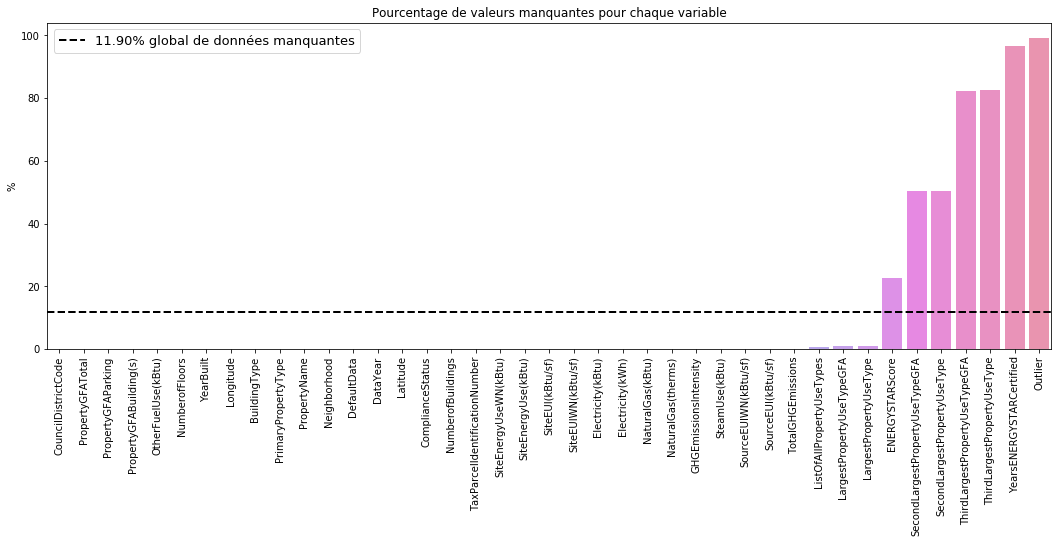

In [30]:
#On calcule la proportion de données manquantes pour chaque colonne et on plot !
fig = plt.figure(figsize=(18,6))

null_prop = data.isnull().sum(axis=0).sum()/len(data)/len(data.columns)*100
plt.axhline(y=null_prop, color='k', linestyle='--', lw=2)
plt.legend(['{:.2f}% global de données manquantes'.format(null_prop)], fontsize=13)

null = data.isnull().sum(axis=0).sort_values()/len(data)*100
sns.barplot(null.index, null.values)
plt.ylabel("%")
plt.title("Pourcentage de valeurs manquantes pour chaque variable")
plt.xticks(rotation=90)
plt.show()

### 2.2 Suppresion des colonnes fortement non renseignés

#### Suppression des variables non renseignés

Les colonnes dont les données manquantes sont supérieurs à 25% sont supprimés

In [31]:
# On supprime les colonnes dont les données manquantes sont supérieurs à 25% (sauf Energy Star Score)
null = data.isnull().sum(axis=0).sort_values()/len(data)*100
cond = null<25
cond = cond[cond == True]
data = data.loc[:, cond.index]

### 2.3 Suppresion des colonnes non pertinentes

In [32]:
# Liste des colonnes qui semblent sans intérêt pour la création d'un modèle prédictif
col_to_del = ["GHGEmissionsIntensity", 
              "NaturalGas(therms)", 
              "DataYear", 
              'TaxParcelIdentificationNumber', 
              'PropertyName']

# Suppression des colonnes non pertinentes
data.drop(columns=col_to_del, inplace=True)

# Nouvelle liste des columns numériques
num_columns = list(data.select_dtypes(include='float64').columns)

### 2.4 Suppresion des valeurs abérantes et  imputations des valeurs manquantes

#### 2.4.1 Valeurs abérantes

In [33]:
(data[num_columns]<=0).sum()

PropertyGFATotal                0
PropertyGFAParking           2463
PropertyGFABuilding(s)          1
OtherFuelUse(kBtu)           3415
NumberofFloors                 16
YearBuilt                       0
Longitude                    3432
Latitude                        0
NumberofBuildings               0
SiteEnergyUseWN(kBtu)           9
SiteEnergyUse(kBtu)             1
SiteEUI(kBtu/sf)                1
SiteEUIWN(kBtu/sf)              9
Electricity(kBtu)               0
Electricity(kWh)                0
NaturalGas(kBtu)             1256
SteamUse(kBtu)               3294
SourceEUIWN(kBtu/sf)           10
SourceEUI(kBtu/sf)              2
TotalGHGEmissions               0
LargestPropertyUseTypeGFA       0
ENERGYSTARScore                 0
dtype: int64

#### Variables Energie totale et CO2

Les bâtiments dont les valeurs cibles sont manquantes ou négatives sont supprimés

In [34]:
for label in ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'] :
    print("Le nombre de bâtiments dont {} est manquant est de : {}".format(label, data[label].isna().sum()))
    print("Le nombre de bâtiments dont {} est <=0 est de : {}".format(label, sum(data[label]<0.0)))
    data = data[data[label]>=0.0] # Suppresion des bâtiments dont la valeur est négative ou nulle

Le nombre de bâtiments dont TotalGHGEmissions est manquant est de : 4
Le nombre de bâtiments dont TotalGHGEmissions est <=0 est de : 0
Le nombre de bâtiments dont SiteEnergyUse(kBtu) est manquant est de : 0
Le nombre de bâtiments dont SiteEnergyUse(kBtu) est <=0 est de : 0


Suppression des valeurs négatives de surface et de bâtiments

In [35]:
for label in ["PropertyGFAParking", "PropertyGFABuilding(s)"] :
    print("Le nombre de bâtiments dont {} est <0 est de : {}".format(label, sum(data[label]<0.0)))
    data = data[data[label]>=0.0]   
    len(data)

Le nombre de bâtiments dont PropertyGFAParking est <0 est de : 2
Le nombre de bâtiments dont PropertyGFABuilding(s) est <0 est de : 1


On s'assure que la consommation de chaque source d'énergie est égale à la consommation totale (marge de 1%)

In [36]:
list_energy = ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', "OtherFuelUse(kBtu)"]
data["diff_energy"] = abs((data[list_energy].sum(axis=1) - data["SiteEnergyUse(kBtu)"]))/(data["SiteEnergyUse(kBtu)"]+0.0001)
print("Le nombre de bâtiments dont la consommation de chaque source d'énergie n'est pas égale à la consommation totale est de : {}" \
      .format(sum(data["diff_energy"]>1e-4)))
data = data[data["diff_energy"]<1e-4]
data.drop(columns=["diff_energy"], inplace=True)
len(data)

Le nombre de bâtiments dont la consommation de chaque source d'énergie n'est pas égale à la consommation totale est de : 57


3368

#### 2.4.2 Traitement des Outliers

Il est intéressant de s'intéressser aux distributions des variables à prédire pour savoir si des bâtiments ont des valeurs outliers soit très hautes ou très basses.

#### Variables énergie et Co2 sans transformation

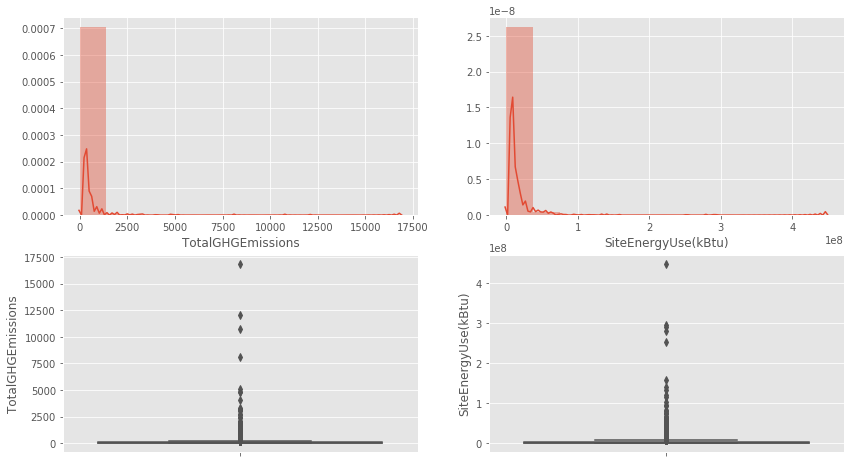

In [37]:
plt.style.use('ggplot')

fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(data[label], bins=int(1 + np.log2(len(data))))
    plt.subplot(2,2,i+3)
    sns.boxplot(data[label], orient="v")
plt.show()

Des bâtiments à forte consommation énergétique et forte émissions de Co2, en nombre non négligeable, rendent la distribution asymétrique

#### Variables énergie et Co2 avec transformation logarithmique

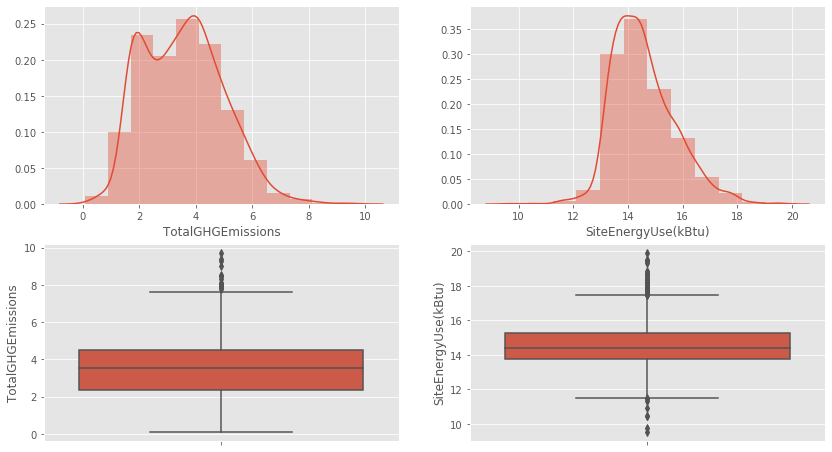

In [38]:
plt.style.use('ggplot')

fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(data[label].apply(lambda x : np.log(1 + x)), bins=int(1 + np.log2(len(data))))
    plt.subplot(2,2,i+3)
    sns.boxplot(data[label].apply(lambda x : np.log(1 + x)), orient="v")
plt.show()

Désormais, nos variables à prédire présentent des distributions "normales", la méthode de Tukey peut être donc appliqué pour supprimer les valeurs outliers.

Calcul des IQ pour l'énergie totale    

In [39]:
Q1 = round(np.percentile(data["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x)), 25))
Q3 = round(np.percentile(data["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x)), 75))

born_sup_energy = Q3 + 1.5*(Q3-Q1)
born_inf_energy = Q1 - 1.5*(Q3-Q1)

Calcul des IQ pour les émissions de Co2

In [40]:
Q1 = round(np.percentile(data["TotalGHGEmissions"].apply(lambda x : np.log(1 + x)), 25))
Q3 = round(np.percentile(data["TotalGHGEmissions"].apply(lambda x : np.log(1 + x)), 75))

born_sup_co2 = Q3 + 1.5*(Q3-Q1) 
born_inf_co2 = Q1 - 1.5*(Q3-Q1)

Suppression des outliers en énergie totale et émissions de Co2

In [41]:
data = data[(data["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x))<born_sup_energy) & (data["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x))>born_inf_energy)]
data = data[(data["TotalGHGEmissions"].apply(lambda x : np.log(1 + x))<born_sup_co2) & (data["TotalGHGEmissions"].apply(lambda x : np.log(1 + x))>born_inf_co2)]

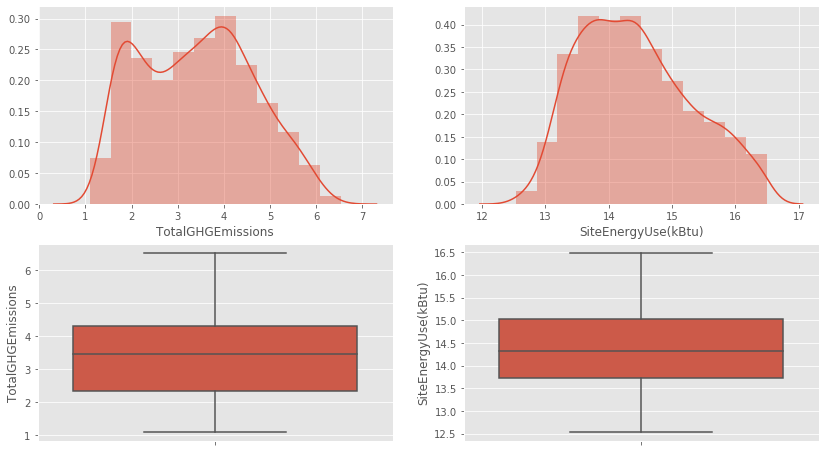

In [42]:
plt.style.use('ggplot')

fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(data[label].apply(lambda x : np.log(1 + x)), bins=int(1 + np.log2(len(data))))
    plt.subplot(2,2,i+3)
    sns.boxplot(data[label].apply(lambda x : np.log(1 + x)), orient="v")
plt.show()

In [43]:
print("Le nombre de bâtiments restant est de : {}".format(len(data)))

Le nombre de bâtiments restant est de : 3107


### 2.5 Variables énergétiques

In [44]:
# On récupère l'énergie totale et les emissions de CO2
TotalEnergyUse = data["SiteEnergyUse(kBtu)"]
TotalCO2 = data["TotalGHGEmissions"]

# On calcule les proportions de chaque source d'énergie 
data["Electricity"] = data["Electricity(kBtu)"]/data["SiteEnergyUse(kBtu)"]
data["NaturalGas"] = data["NaturalGas(kBtu)"]/data["SiteEnergyUse(kBtu)"]
data["SteamUse"] = data["SteamUse(kBtu)"]/data["SiteEnergyUse(kBtu)"]
data["OtherFuelUse"] = data["OtherFuelUse(kBtu)"]/data["SiteEnergyUse(kBtu)"]

In [45]:
# On supprime les colonnes renseignant les quantités d'énergie (kBtu et kWh) et de CO2 émis
col_to_del = []
for col in data :
    if ('kBtu' in col) or  ('kWh' in col) or ('CO2' in col) :
        col_to_del.append(col)
        

data.drop(columns=col_to_del, inplace=True)

# On récupère l'énergie totale et les emissions de CO2
data["SiteEnergyUse(kBtu)"] = TotalEnergyUse
data["TotalGHGEmissions"] = TotalCO2

In [46]:
print("Le nombre de bâtiments restant est de : {}".format(len(data)))

Le nombre de bâtiments restant est de : 3107


#### Sauvegarde des données

In [47]:
data.to_csv(os.path.join(path, "data_clean.csv"))

### 2.6 Corrélation entre variables

La matrice de corrélation permet de déterminer si certaines informations ne sont pas redondantes

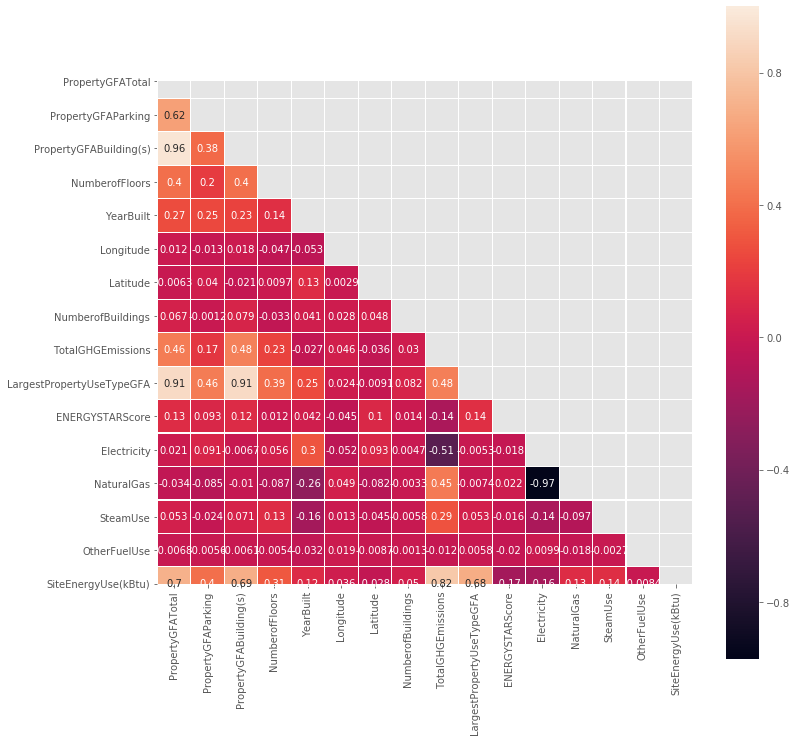

In [48]:
corr_matrix = data.corr()
fig = plt.figure(1, figsize=(12,12))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, square=True, linewidths=0.1, annot=True)
plt.show()

- La consommation totale d'énergie est fortement corrélé à la surface des bâtiments
- Les émissions de Co2 sont fortement corrélés à la consommation totale d'énergie
- Les features 'LargestPropertyUseTypeGFA' et 'PropertyGFATotal' sont fortement corrrélés avec 'PropertyGFABuilding(s)' donc supprimés pour éviter la redondance d'informations

In [49]:
# Suppression des features 'LargestPropertyUseTypeGFA' et 'PropertyGFATotal'
data.drop(columns=['LargestPropertyUseTypeGFA', 'PropertyGFATotal'], inplace=True)

##### Matrice de corrélation après suppression de doublons d'informations

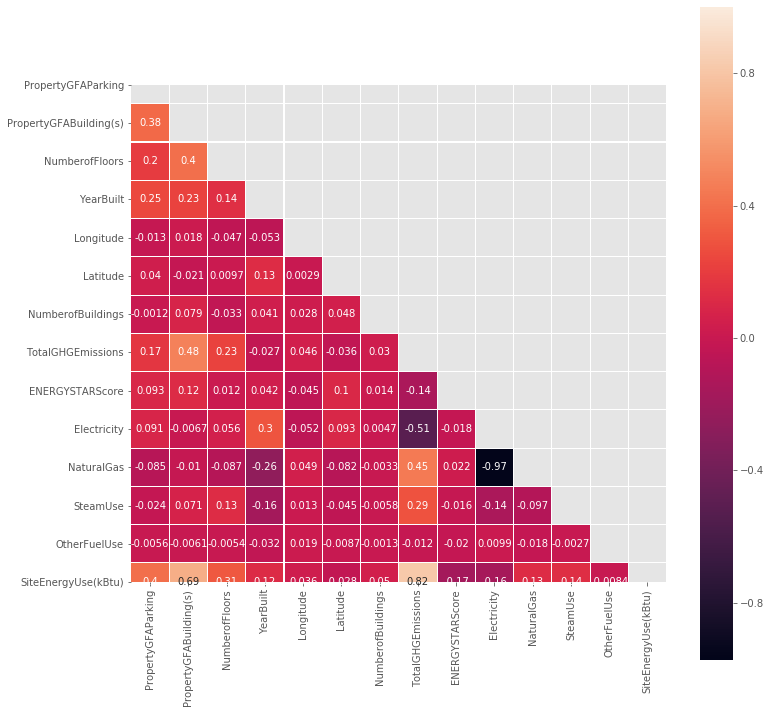

In [50]:
corr_matrix = data.corr()
fig = plt.figure(1, figsize=(12, 12))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, square=True, linewidths=0.1, annot=True)
plt.show()

- Désormais il n'y a plus de corrélations fortes entre les features

## 3. Analyse des données

On récupère le nom des variables prédictibles, catégorielles et numériques

In [51]:
# Variables prédictives
y_labels = ["SiteEnergyUse(kBtu)", "TotalGHGEmissions", 'Electricity', 'NaturalGas', 'SteamUse', "OtherFuelUse"]

# Variables catégorielles
cat_attribs = list(data.select_dtypes(include='object').columns) + ["CouncilDistrictCode"]

# Variables numériques
num_attribs = list(data.drop(columns=cat_attribs + y_labels + ["ENERGYSTARScore"]).columns)

- La variable "CouncilDistrictCode" est de type float mais il s'agit plutôt d'une variable catégorielle

### 3.1 Géolocalisation des bâtiments

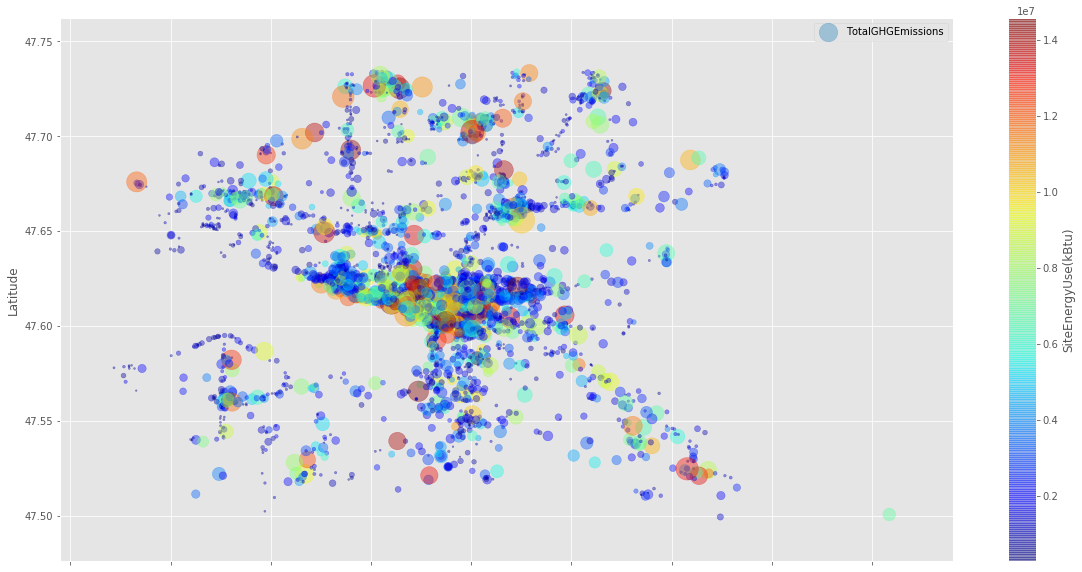

In [52]:
data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
            s=data["TotalGHGEmissions"], label="TotalGHGEmissions",
            c="SiteEnergyUse(kBtu)", cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(20,10))
plt.show()

- Il y a une très forte densité de bâtiments au centre géographique

- Il y a quelques bâtiments outliers en consommation d'énergie totale

- Il n'y pas de séparation visuellement franche

### 3.2 Distribution des variables numériques

#### Variables indicatives (features)

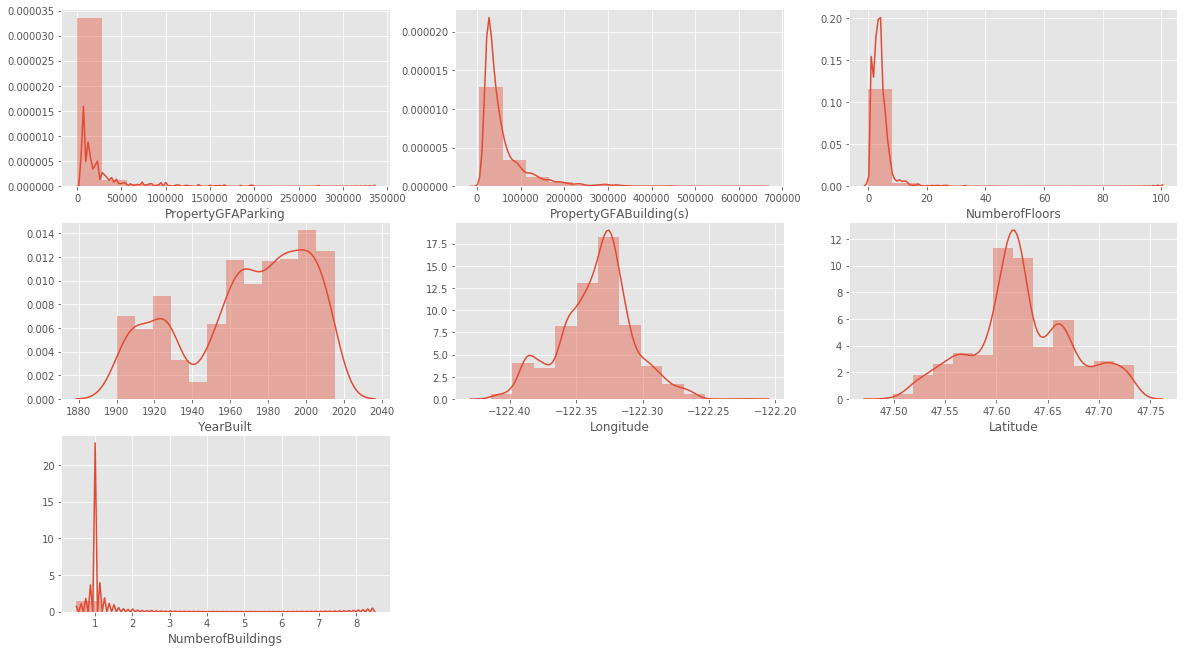

In [53]:
plt.style.use('ggplot')
fig = plt.figure(1, figsize=(20, 15))
for i,label in enumerate(num_attribs) :
    plt.subplot(4,3,i+1)
    sns.distplot(data[label], bins=int(1 + np.log2(len(data))))
plt.show()

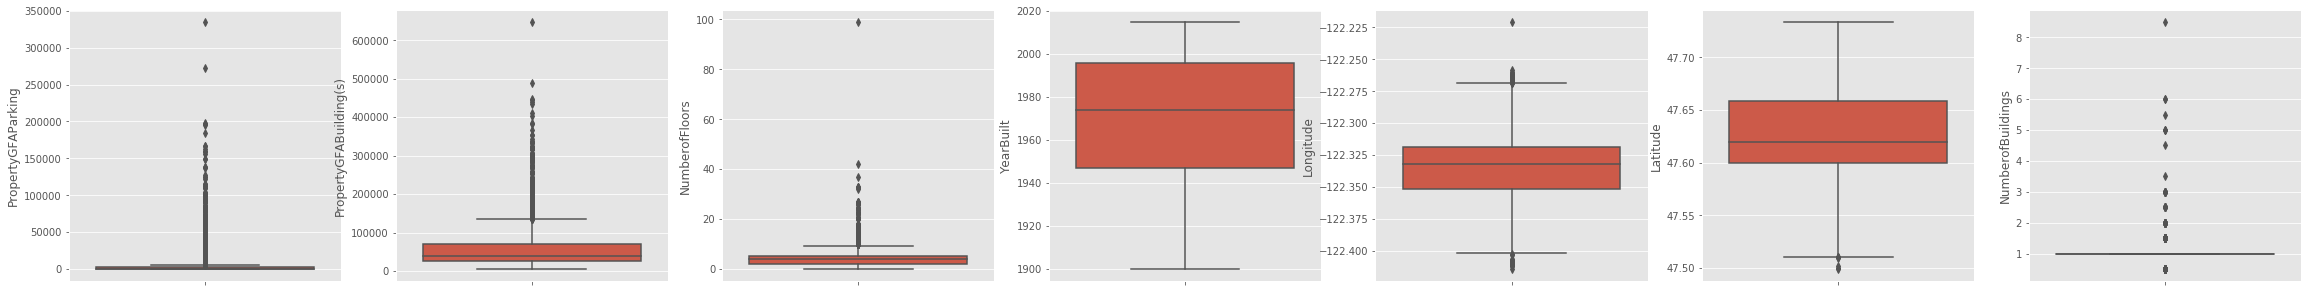

In [54]:
fig = plt.figure(1, figsize=(40, 5))
for i,label in enumerate(num_attribs) :
    plt.subplot(1,len(num_attribs), i+1)
    sns.boxplot(data[label], orient="v")
plt.show()

- Les bâtiments les plus anciens ont été construits en 1900 et les plus récents en 2015
- La distribution de 'NumberofFloors' indique la présence de bâtiments plain-pieds aux gratte ciels
- La plus part des individus de notre échantillon de données présentent un seul bâtiment
- La médianne et la valeur la plus fréquente pour le nombre d'étages est de 4

#### Variables à prédire

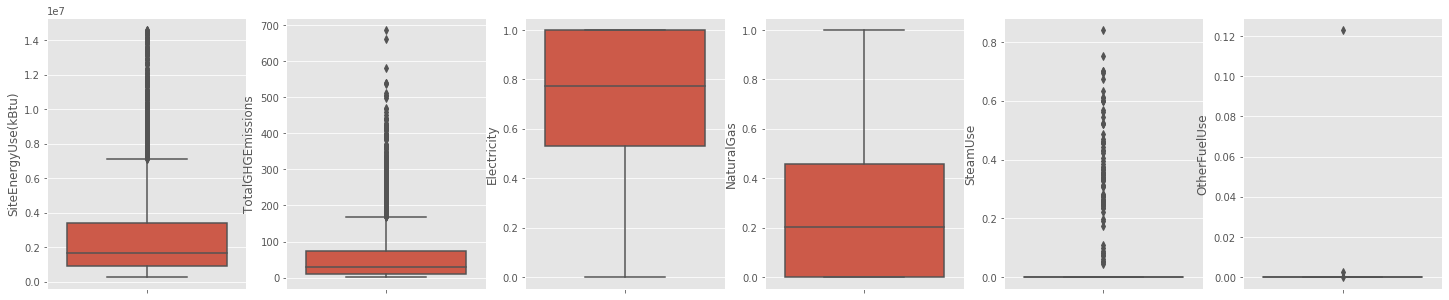

In [55]:
fig = plt.figure(1, figsize=(25, 5))
for i,label in enumerate(y_labels) :
    plt.subplot(int("1" + str(len(y_labels)) + str(i+1)))
    sns.boxplot(data[label], orient="v")
plt.show()

- La plus part des bâtiments ont une consommation de "SteamUse" quasi nulle, la balance énergétique se fait entre l'électricité et le gas naturel, et avec la 'Steam' pour quelques bâtiments

- Certains bâtiments sont des outliers en consommation d'énergie, ils sont trop peu nombreux à avoir une consommation supérieur à 1e8 kBtu

### 3.3 Variables catégorielles

Nombre de valeurs différentes pour chaque variable catégorielle

In [56]:
data[cat_attribs].nunique()

CouncilDistrictCode            9
BuildingType                   8
PrimaryPropertyType           26
Neighborhood                  19
DefaultData                    2
ComplianceStatus               4
ListOfAllPropertyUseTypes    406
LargestPropertyUseType        54
CouncilDistrictCode            9
dtype: int64

Distribution des valeurs pour chaque variable catégorielle

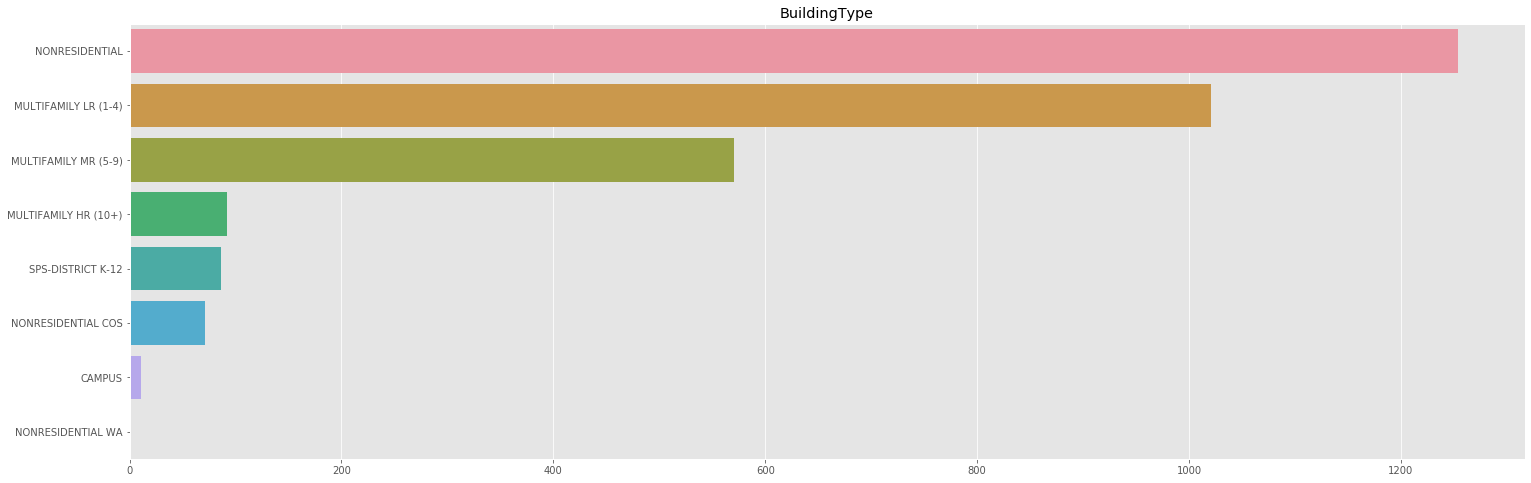

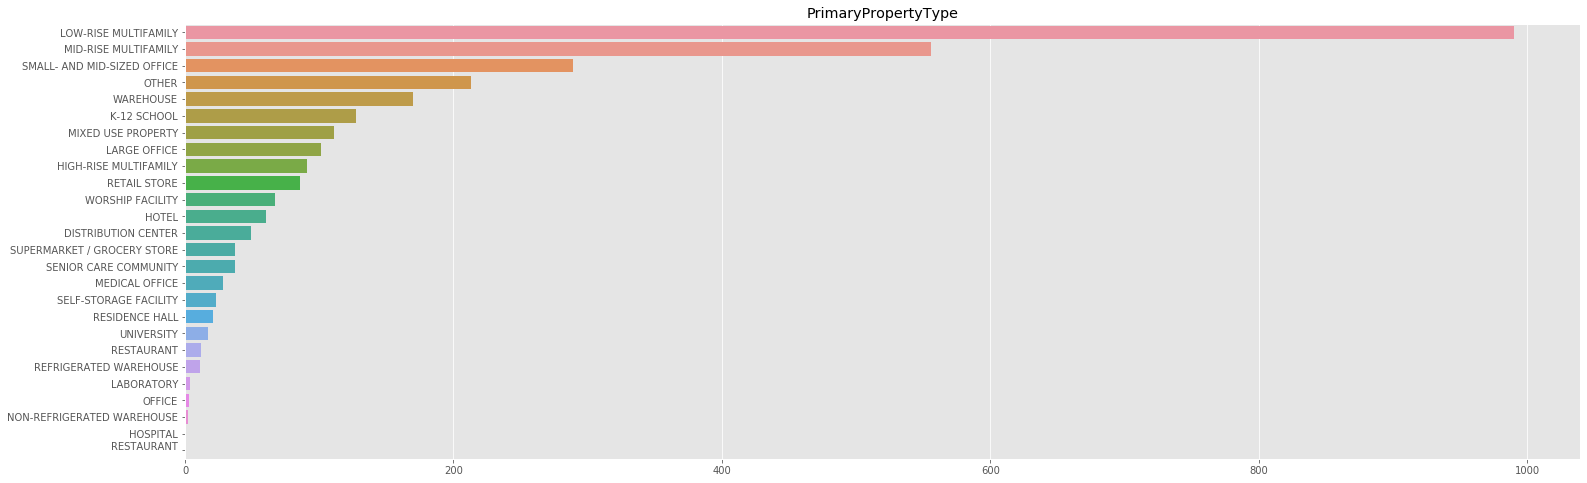

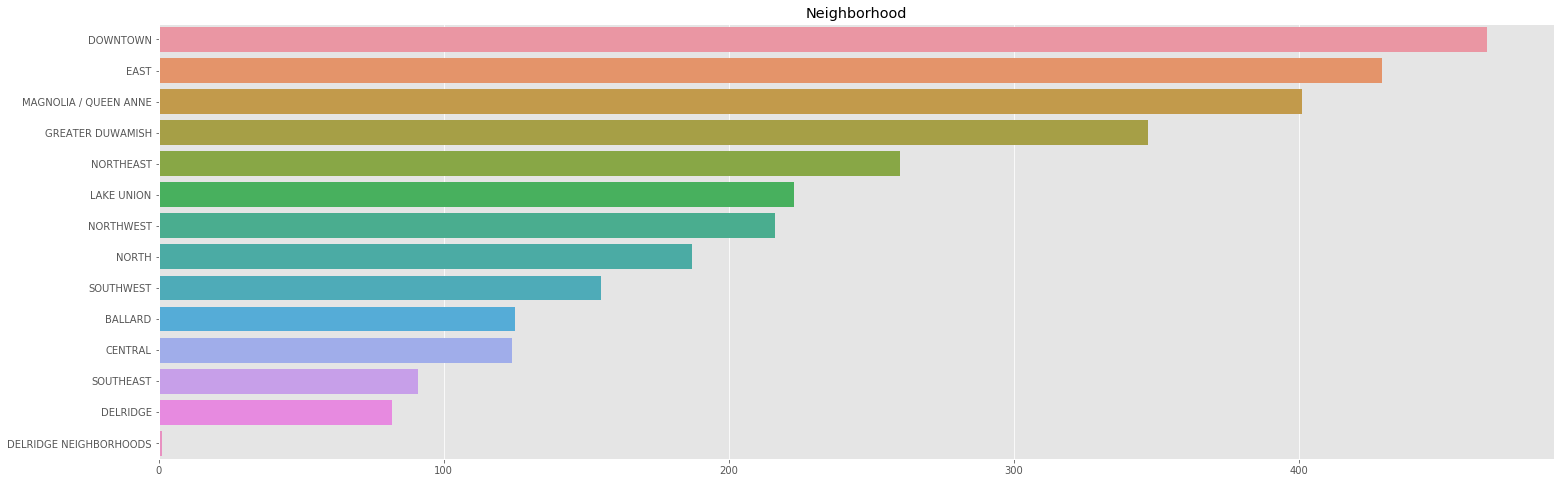

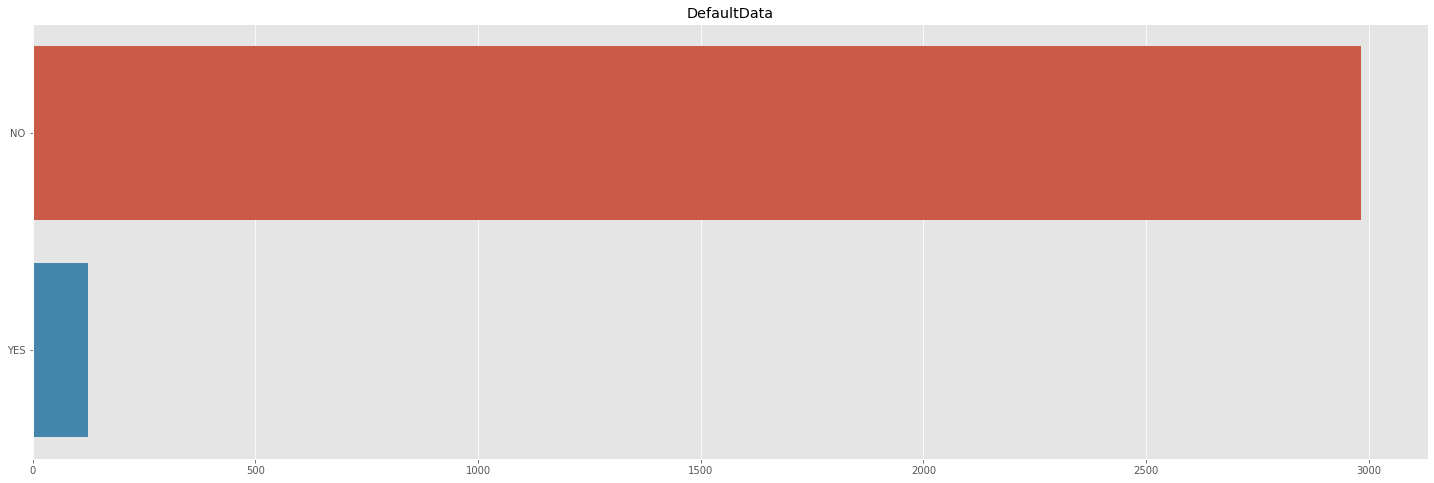

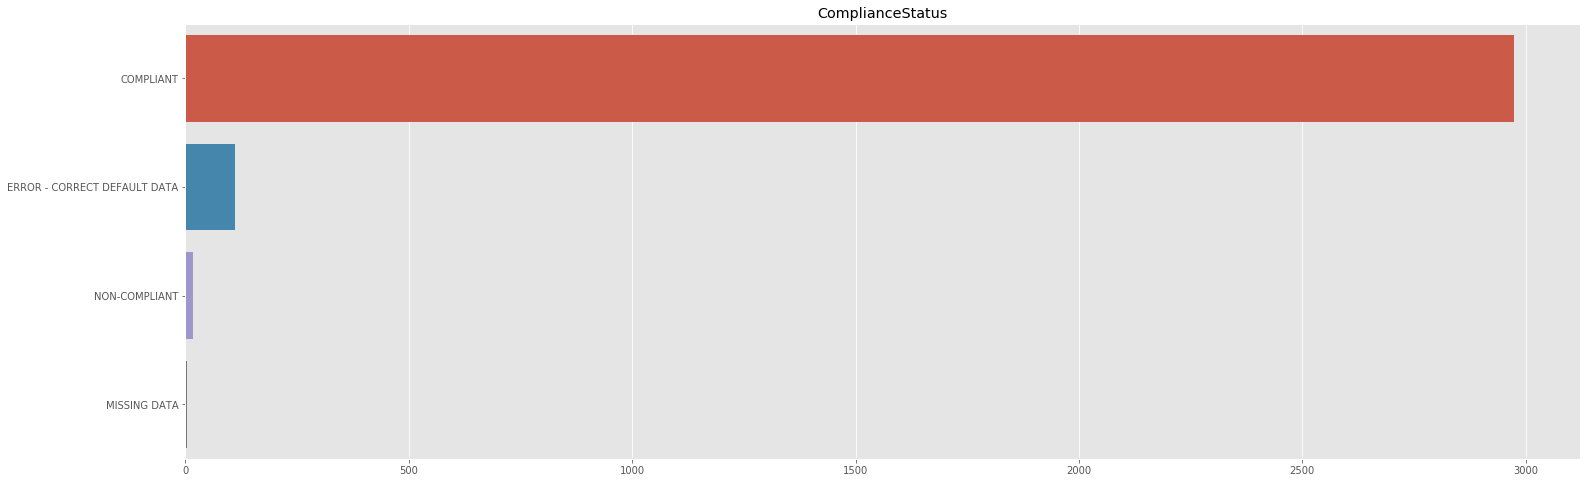

In [57]:
# Toutes les variables catégorielles sauf "ListOfAllPropertyUseTypes" et "LargestPropertyUseType"
cat_attribs_to_plot = list(data[cat_attribs].drop(columns=["ListOfAllPropertyUseTypes", "LargestPropertyUseType", 'CouncilDistrictCode']).columns)

for cat in cat_attribs_to_plot :
    fig = plt.figure(1, figsize=(25,8))
    data[cat] = data[cat].str.upper()
    df_cat = data[cat].value_counts()
    plt.title(cat)
    sns.barplot(df_cat.values, df_cat.index)
    plt.show()

- Les variables PrimaryPropertyType, ListOfAllPropertyUseTypes et LargestPropertyUseType indiquent globalement des types de propriété

#### Boxplot de la colonne 'PrimaryPropertyType'

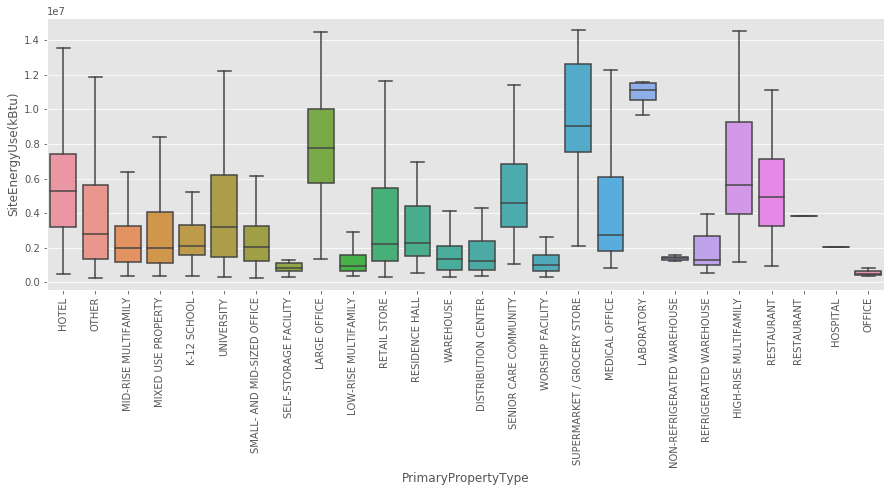

In [58]:
fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=data, x="PrimaryPropertyType" , y="SiteEnergyUse(kBtu)", showfliers=False)
plt.xticks(rotation=90)
plt.show()

Nombre de valeurs par type de bâtiments

In [59]:
data["PrimaryPropertyType"].value_counts()

LOW-RISE MULTIFAMILY           990
MID-RISE MULTIFAMILY           556
SMALL- AND MID-SIZED OFFICE    289
OTHER                          213
WAREHOUSE                      170
K-12 SCHOOL                    127
MIXED USE PROPERTY             111
LARGE OFFICE                   101
HIGH-RISE MULTIFAMILY           91
RETAIL STORE                    86
WORSHIP FACILITY                67
HOTEL                           60
DISTRIBUTION CENTER             49
SUPERMARKET / GROCERY STORE     37
SENIOR CARE COMMUNITY           37
MEDICAL OFFICE                  28
SELF-STORAGE FACILITY           23
RESIDENCE HALL                  21
UNIVERSITY                      17
RESTAURANT                      12
REFRIGERATED WAREHOUSE          11
LABORATORY                       4
OFFICE                           3
NON-REFRIGERATED WAREHOUSE       2
HOSPITAL                         1
RESTAURANT\n                     1
Name: PrimaryPropertyType, dtype: int64

In [60]:
# Suppresion des types Hospital et Restaurant
data = data[~data["PrimaryPropertyType"].isin(["HOSPITAL", "RESTAURANT\n"])]

Les bâtiments de type 'Hospital' et 'Restaurant' sont suppprimés car présents 1 seule fois dans le jeu de données

## 4. Préparation des données

#### Transformation logarithmiques des variables à prédire

In [61]:
data.loc[:, ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]] = data.loc[:, ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]].apply(lambda x : np.log(1 + x))

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Liste des variables catégorielles et numériques

In [62]:
# Variables catégorielles
cat_attribs = list(data.select_dtypes(include=['object']).columns)

# Variables numériques
num_attribs = list(data.drop(columns=cat_attribs + y_labels + ["ENERGYSTARScore"]).columns)

### 4.1 Séléction des attributs

In [63]:
# Création d'une classes qui permet de séléctionner les variables numériques ou catégorielles 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

### 4.2 Ajout de variables supplémentaires
- Surface totale = Surface au sol * Nombre d'étages

In [64]:
PropertyGFABuilding_ix, NumberOfBuildings_ix, NumberofFloors_ix = 1, 6, 2 

class CombinedAttributesAdder(BaseEstimator, TransformerMixin) :
    
    def __init__(self, add_GFA_per_floor_per_building=True) :
        self.add_GFA_per_floor_per_building = add_GFA_per_floor_per_building
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.add_GFA_per_floor_per_building :
            BuildingGFA_per_floor = X[:, PropertyGFABuilding_ix]*X[:, NumberofFloors_ix]
            return np.c_[X, BuildingGFA_per_floor]
        else : 
            return X 

- Variables booléennes des energies

In [65]:
Electricity_ix, NaturalGas_ix, SteamUse_ix, OtherFuel_ix = 0, 1, 2, 3

class AddBooleanEnergyType(BaseEstimator, TransformerMixin) :
    
    def __init__(self, add_Boolean_EnergyType=True) :
        self.add_Boolean_EnergyType = add_Boolean_EnergyType
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.add_Boolean_EnergyType :
            
            Electricity_boolean = [0 if x == 0 else 1 for x in X[:, Electricity_ix]]
            NaturalGas_boolean = [0 if x == 0 else 1 for x in X[:, NaturalGas_ix]]
            SteamUse_boolean = [0 if x == 0 else 1 for x in X[:, SteamUse_ix]]
            OtherFuel_boolean = [0 if x == 0 else 1 for x in X[:, OtherFuel_ix]]
            
            return np.c_[Electricity_boolean, NaturalGas_boolean, SteamUse_boolean, OtherFuel_boolean]
        else : 
            return X 

### 4.3 Pipelines numériques et catégorielles

#### 4.3.1 Définitions des pipelines

In [66]:
# Pipeline pour les variables numériques
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)), # Selection des variables numériques
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    ('attribs_combined', CombinedAttributesAdder()), # Feature engineering
    ('std_scaler', StandardScaler()), # Normalisation des données
    ])

# Pipeline pour les variables catégorielles
cat_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(cat_attribs)), # Selection des variables catégorielles
    ('target', TargetEncoder()),
    ('std_scaler', StandardScaler()), # Normalisation des données
    ('imputer', SimpleImputer(strategy='mean')), # Inputation des valeurs manquantes
    
    ])

# Pipeline pour les variables booléennes
add_bool_pipeline = Pipeline([
    ('selector', DataFrameSelector(["Electricity",
                                    "NaturalGas",
                                    "SteamUse",
                                    "OtherFuelUse"])), # Selection des types d'énergie
    ('bool_energy', AddBooleanEnergyType()) # Les types sont converties en variables booléennes
])

#### 4.3.2 Transformations pour modèles linéaires

Pour un modèle linéaire, les variables catégorielles sont encodés avec un OneHotEncoder.

Cependant, il n'est donc pas possible de séléctionner toutes les variables catégorielles c'est pourquoi seuls quelques variables ont été jugés plus importantes que d'autres. Une seule variable contenant les types de bâtiments a été séléctionné; de même pour les quartiers.

#### 4.3.3 Transformations pour modèles non-linéaires

Toutes les variables catégorielles sont conservés et sont transformés pour chacune via un LabelEncoder

In [67]:
# Labelize les variables catégorielles et les ajoute aux variables numériques transformés
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("energyType", add_bool_pipeline, ["Electricity",
                                           "NaturalGas",
                                           "SteamUse",
                                           "OtherFuelUse"]),
        ("cat", cat_pipeline, cat_attribs),
    ])

### 4.4 Séparation du jeu de données en jeu d'entrainement et de test

#### 4.4.1 Séparation 80% entrainement, 20% test

In [68]:
# Split en jeu d'entrainement et de test
train_set, test_set = train_test_split(data, train_size=0.8, random_state=0)

### 4.5 Sélection des étiquettes

In [69]:
y_labels = ["SiteEnergyUse(kBtu)",
            "TotalGHGEmissions",
            'Electricity',
            'NaturalGas',
            'SteamUse',
            "OtherFuelUse"]

## 5. Sélection et entrainement de modèles

#### Méthodologie :

Ce projet se porte sur la prédiction de deux variables, la première est la consommation d'énergie et la deuxième est les émissions de Co2.

Nous allons procéder ainsi :

1) La consommation d'énergie totale est prédite en utilisant l'ensemble des variables à notre disposition ainsi que les variables booléans renseignant les types d'énergie utilisés par la structure. Par exemple, si un bâtiment utilise comme source d'énergie l'électricité, la valeur 1 est attribué sinon 0, ainsi de suite pour tous les types d'énergie
    
2) La proportion utilisé de chaque type d'énergie est prédite (en utilisant également les variables booléennes)
    
3) Les émissions de Co2 sont prédites en utilisant les variables propres au bâtiment, ainsi que la prédiction de la consommation d'énergie totale et la proportion de chaque type d'énergie

#### Métriques

Dans cette partie, deux métriques sont utilisés : la MAE et la RMSE

La RMSE est plus sensible que la MAE aux valeurs s'écartant de la normale, ce qui permet de mieux traiter les écarts importants, c'est pourquoi la RMSE est préféré et sera utilisé pour la séléction des modèles finaux.

<img src="rmse.png">

- ŷi : valeur prédite
- yi : valeure réelle

Une autre métrique est utilisé en complément pour avoir une idée plus parlante de la qualité d'un modèle, il s'agit du coefficient de détermination qui s'exprime de la manière suivante :


<img src="r2.png">

R² varie entre -1 et 1. Plus il est proche de 1 et plus les valeurs prédites et réelles sont corrélés

#### Transformations des variables

##### Target Encoding
Les variables catégorielles sont transformés par un target_encoder.

Le target encoding consiste à remplacer la valeur de chaque variable catégorielle par la moyenne de la cible des individus ayant la même valeur pour la variable catégorielle

##### Standard Scaler

<img src="std.png">

In [70]:
# Dictionnaires de résultats
y_pred = {}
rmse = {}
mae = {}
final_model = {}

# Résultats, moyenne et écart-type
def display_scores(scores, scoring=["neg_mean_squared_error", "neg_mean_absolute_error"]) :
    
    print("Resultats de la cross validation :")
     
    for metric in scoring : 
    
        print("Métrique utilisé : {} \n".format(metric))
        results = -scores["test_" + metric]
        if metric == "neg_mean_squared_error" :
            results = np.sqrt(results)
        print("\t - Moyenne :", results.mean())
        print("\t - Ecart-type :", results.std())
        print("\t - Coefficient de variation : {:.2f} %".format(results.std()/results.mean()*100))
        print("\n")

In [71]:
# Fonction de cross-validation
def cross_val(estimator, X, y) :
    
    kf = KFold(n_splits=10)

    # cross validation avec 2 métriques
    scores = cross_validate(estimator,
                            X,
                            y, 
                            scoring=["neg_mean_squared_error",
                                     "neg_mean_absolute_error"],
                            cv=kf)
    
    return scores

In [72]:
# MAPE : Mean aboslute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 5.1 Prédiction de l'énergie totale

In [73]:
def define_pipeline(preprocessor, regressor) :
    # Assembly of preprocessor and regressor
    pipe = Pipeline([("preprocess", preprocessor),
                    ("regressor", regressor),
                    ])
    return pipe

In [74]:
# Dictionnaire de regresseurs
regressors = {                   
                   'Dummy': DummyRegressor(),
                   'Elastic Net' : ElasticNet(),
                   'SVR': SVR(kernel="rbf", C=300, gamma=1),
                   'Random Forest': RandomForestRegressor(n_estimators=100, n_jobs=-1),
                   'Extra Tree': ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
                   'Gradient Boosting': GradientBoostingRegressor(n_estimators=100),
                  }

In [75]:
# Les regressors sont testés 1 à 1 par cross-validation
for name_reg, reg in regressors.items() :
    print("_____", name_reg, "_____")
    
    pipeline = define_pipeline(full_pipeline, reg) 
    # cross-validation
    scores = cross_val(pipeline,
                       train_set,
                       train_set["SiteEnergyUse(kBtu)"])
    # calcul de la RMSE
    rmse[name_reg] = np.sqrt(-scores["test_neg_mean_squared_error"])
    # calcul de la MAE
    mae[name_reg] = -scores["test_neg_mean_absolute_error"]

    # Affichage des résultats
    display_scores(scores,
                   scoring = ["neg_mean_squared_error",
                              "neg_mean_absolute_error"])

_____ Dummy _____
Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.8855288446646569
	 - Ecart-type : 0.0303695438748914
	 - Coefficient de variation : 3.43 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 0.7305075560036323
	 - Ecart-type : 0.02473215038400633
	 - Coefficient de variation : 3.39 %


_____ Elastic Net _____
Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.8557068264291301
	 - Ecart-type : 0.031497709538583614
	 - Coefficient de variation : 3.68 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 0.7072017861900642
	 - Ecart-type : 0.025808961175402698
	 - Coefficient de variation : 3.65 %


_____ SVR _____
Resultats de la cross validation :
Métrique utilisé : neg_mean_squared_error 

	 - Moyenne : 0.6914955740379767
	 - Ecart-type : 0.04169287246342835
	 - Coefficient de variation : 6.03 %


Métrique utilisé : neg_mean_absolute_error 

	 - Moyenne : 0.526

#### 5.1.1 Modèle Quick & Dirty

In [76]:
# Fonction qui permet d'afficher un barplot des résultats : moyenne, écart-type et coefficient de variation
def graphical_display(results, title) :
    
    x = list(results)
    y = np.array(list(results.values()))
    rmse_mean = [score.mean() for score in np.array(list(results.values()))]
    rmse_std = [score.std() for score in np.array(list(results.values()))]


    fig = plt.figure(1, figsize=(10,5))
    
    # Barplot de la moyenne
    plt.subplot(311)
    sns.barplot(x=x, y=rmse_mean)
    plt.ylabel("Moyenne")
    plt.title(title)
    
    # Barplot de l'écart-type
    plt.subplot(312)
    sns.barplot(x=x, y=rmse_std)
    plt.ylabel("Ecart-Type")
    
    # Barplot du coefficient de variation
    plt.subplot(313)
    sns.barplot(x=x, y=[r1/r2*100 for r1,r2 in zip(rmse_std,rmse_mean)])
    plt.ylabel("Coeff de variation")

    plt.show()

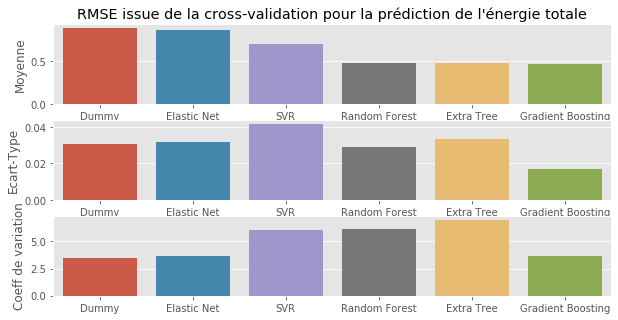

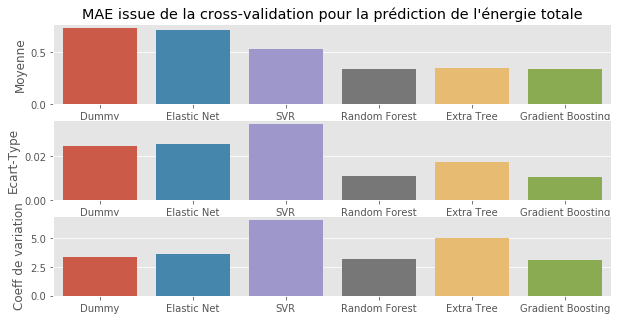

In [77]:
# Affichage des résultats de la RMSE
graphical_display(rmse, "RMSE issue de la cross-validation pour la prédiction de l'énergie totale")

# Affichage des résultats de la MAE
graphical_display(mae, "MAE issue de la cross-validation pour la prédiction de l'énergie totale")

In [78]:
print("La performance du modèle en RMSE pour l'ExtraTree est d'environ : {:.2f} +- {:.2f}".format(rmse["Extra Tree"].mean(), rmse["Extra Tree"].std()))
print("La performance du modèle en RMSE pour le Random Forest est d'environ : {:.2f} +- {:.2f}".format(rmse["Random Forest"].mean(), rmse["Random Forest"].std()))
print("La performance du modèle en RMSE pour le Gradient Boosting est d'environ : {:.2f} +- {:.2f}".format(rmse["Gradient Boosting"].mean(), rmse["Gradient Boosting"].std()))

La performance du modèle en RMSE pour l'ExtraTree est d'environ : 0.48 +- 0.03
La performance du modèle en RMSE pour le Random Forest est d'environ : 0.47 +- 0.03
La performance du modèle en RMSE pour le Gradient Boosting est d'environ : 0.46 +- 0.02


- 3 Modèles se démarquent des autres et offrent sensiblement les mêmes résultats, il s'agit de :
 #### Random Forest, Gradient de boosting,  Extra Tree

Dans la partie qui suit, nous cherchons à hyper-paramétriser ces 3 modèles dans le but d'affiner les résultats

#### 5.1.8 Réglage du meilleur modèle

In [79]:
def RndSearchCV(estimator, param_grid, X, y) :
    
    # Distribution des indices train/validation pour obtenir des jeux train/validation.
    # Divise le jeu de données en k partitions
    kf = KFold(n_splits=5)

    # Recherhe par quadrillage avec un Extra Tree Forest
    search_cv = RandomizedSearchCV(estimator, param_grid,
                                   scoring='neg_mean_squared_error',
                                   cv=kf,
                                   n_iter=100,
                                   random_state=42)


    # Entrainement de modèles et évaluation sur les données d'entrainement
    search_cv.fit(X, y)
    score = search_cv.best_estimator_.score(X, y)
    print("Hyperparamètres du meilleur modèle :", search_cv.best_params_)
    print("r2 score sur tout le jeux d'entrainement: ", score)
    print("rmse sur le jeu de validation:", np.sqrt(-search_cv.best_score_))
    print("\n")

    return search_cv

In [80]:
def SelectBestModel(regressors, pipeline, param_grid, X, y) :
    
    """
    Optimise une liste d'estimateurs et retourne le meilleur
    regressors(dict): Dictionnaire d'estimateurs, {"name_estimator_1" : estimator_1}
    pipeline : pipeline de transformation de données
    param_grid(dict) : dictionnaire de dictionnaires de paramètres, {"name_estimator_1": dict_params}
    X(np.array): jeux de données
    y(np.array): prédiction
    
    
    """
    
    # Meilleur score
    best_score = float('inf')
    # Dictionnaire des modèles hyperparamétrés
    resultats = {}

    for name_reg, regressor in regressors_2.items() :
    
        print(name_reg)

        prepare_select_and_predict_pipeline = define_pipeline(pipeline, regressor)

    
        grid_search_prep = RndSearchCV(prepare_select_and_predict_pipeline,
                                       param_grid[name_reg],
                                       X,
                                       y)
        resultats[name_reg] = np.sqrt(-grid_search_prep.best_score_)
        if  np.abs(grid_search_prep.best_score_) < np.abs(best_score) :
            best_score = grid_search_prep.best_score_
            best_model = grid_search_prep.best_estimator_
            
    # Graphique des résultats de l'hyper-paramétrisation
    fig = plt.figure(1, figsize=(10,5))
    sns.barplot(x=list(resultats.keys()), y=list(resultats.values()))
    plt.title("RMSE sur jeux de validation, issue de l'hyperparamétrisation des modèles")
    plt.ylabel('RMSE')
    plt.show()

        
            
    return best_model

In [81]:
regressors_2 = {
                'Gradient Boosting': GradientBoostingRegressor(random_state=42),
                'Random Forest': RandomForestRegressor(random_state=42),
                'Extra Forest': ExtraTreesRegressor(random_state=42)   
}

Gradient Boosting
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 150, 'regressor__max_features': 6, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.05, 'preprocess__num__imputer__strategy': 'mean', 'preprocess__cat__imputer__strategy': 'mean'}
r2 score sur tout le jeux d'entrainement:  0.9059729863226876
rmse sur le jeu de validation: 0.46364324126884354


Random Forest
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 150, 'regressor__max_features': 4, 'regressor__max_depth': 18, 'preprocess__num__imputer__strategy': 'median', 'preprocess__cat__imputer__strategy': 'mean'}
r2 score sur tout le jeux d'entrainement:  0.9567076972405935
rmse sur le jeu de validation: 0.47332089076839295


Extra Forest
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 100, 'regressor__max_features': 14, 'regressor__max_depth': 18, 'preprocess__num__imputer__strategy': 'median', 'preprocess__cat__imputer__strategy': 'mean'}
r2 score sur tout le jeux d

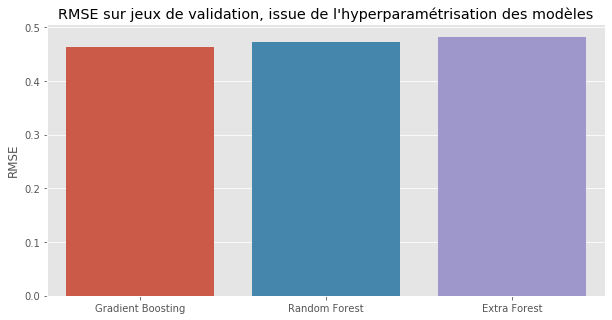

In [82]:
# Hyperparamères pour les modèles ensemblistes d'arbres de regression
param_grid_reg_tree = {
    'preprocess__num__imputer__strategy': ['mean', 'median', 'most_frequent'],# Méthode d'imputation des variables numériques
    'preprocess__cat__imputer__strategy': ['mean', 'median'], # Méthode d'imputation des variables catégorielles
    'regressor__n_estimators' : [100, 150], # Nombre d'arbres
    'regressor__max_depth' : range(2, 20, 2), # Nombre de profondeurs maximums
    'regressor__max_features' : range(2, 20, 2) # Nombre de maximum de features
}

# Ajout du paramètre learning rate pour le Gradient Boosting
param_grid_gb = param_grid_reg_tree.copy()
param_grid_gb["regressor__learning_rate"] = [0.01, 0.05, 0.1]

# Dictionnaire de grille de paramètres
param_grid = {'Gradient Boosting': param_grid_gb,
              'Random Forest': param_grid_reg_tree,
              'Extra Forest': param_grid_reg_tree,
             }

# Selection du meilleur modèle
final_model["SiteEnergyUse(kBtu)"] = SelectBestModel(regressors_2, 
                                                     full_pipeline,
                                                     param_grid,
                                                     train_set,
                                                     train_set["SiteEnergyUse(kBtu)"])

Le Gradient Boosting est celui qui donne les meilleurs résultats par validation croisé. Ce modèle fait moins d'over-fitting sur le jeu d'entrainement car c'est celui qui présente le r2_score le plus faible sur le jeu d'entrainement. Il se généralise mieux sur les données qu'il n'a pas apprise comme sur les jeux de validation.

### 5.2 Prédiction proportions d'énergie

#### Hyperparamétrisation des modèles séléctionnés

______________Electricity______________
Gradient Boosting
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 100, 'regressor__max_features': 6, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.05, 'preprocess__num__imputer__strategy': 'median', 'preprocess__cat__imputer__strategy': 'mean'}
r2 score sur tout le jeux d'entrainement:  0.7385908592466459
rmse sur le jeu de validation: 0.1562816237182171


Random Forest
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 150, 'regressor__max_features': 8, 'regressor__max_depth': 10, 'preprocess__num__imputer__strategy': 'most_frequent', 'preprocess__cat__imputer__strategy': 'median'}
r2 score sur tout le jeux d'entrainement:  0.8459637081008017
rmse sur le jeu de validation: 0.15534011656724694


Extra Forest
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 100, 'regressor__max_features': 16, 'regressor__max_depth': 12, 'preprocess__num__imputer__strategy': 'mean', 'preprocess__cat__imputer

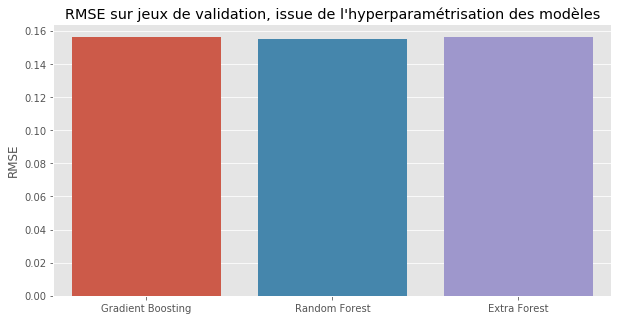

______________NaturalGas______________
Gradient Boosting
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 100, 'regressor__max_features': 18, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.05, 'preprocess__num__imputer__strategy': 'mean', 'preprocess__cat__imputer__strategy': 'mean'}
r2 score sur tout le jeux d'entrainement:  0.733689561194058
rmse sur le jeu de validation: 0.15536665378392592


Random Forest
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 100, 'regressor__max_features': 6, 'regressor__max_depth': 10, 'preprocess__num__imputer__strategy': 'mean', 'preprocess__cat__imputer__strategy': 'mean'}
r2 score sur tout le jeux d'entrainement:  0.8364188365023207
rmse sur le jeu de validation: 0.15450757121284117


Extra Forest
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 150, 'regressor__max_features': 12, 'regressor__max_depth': 14, 'preprocess__num__imputer__strategy': 'median', 'preprocess__cat__imputer__strategy'

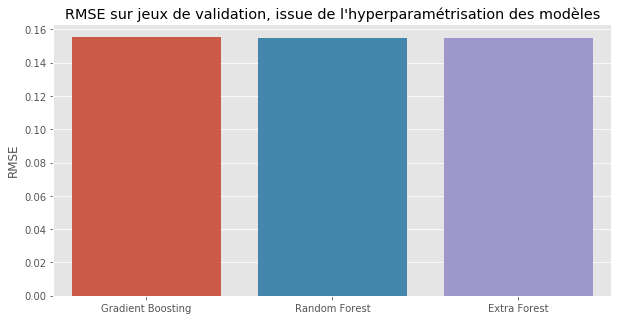

______________SteamUse______________
Gradient Boosting
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 100, 'regressor__max_features': 10, 'regressor__max_depth': 16, 'regressor__learning_rate': 0.05, 'preprocess__num__imputer__strategy': 'median', 'preprocess__cat__imputer__strategy': 'median'}
r2 score sur tout le jeux d'entrainement:  0.9999641452060577
rmse sur le jeu de validation: 0.02892228926522938


Random Forest
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 150, 'regressor__max_features': 10, 'regressor__max_depth': 12, 'preprocess__num__imputer__strategy': 'median', 'preprocess__cat__imputer__strategy': 'mean'}
r2 score sur tout le jeux d'entrainement:  0.9752605417047526
rmse sur le jeu de validation: 0.028672741753160615


Extra Forest
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 150, 'regressor__max_features': 16, 'regressor__max_depth': 2, 'preprocess__num__imputer__strategy': 'most_frequent', 'preprocess__cat__impu

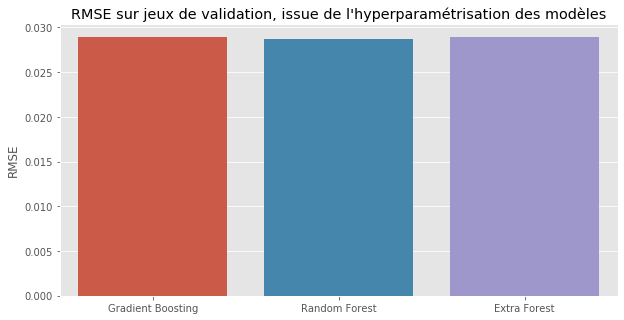

______________OtherFuelUse______________
Gradient Boosting
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 100, 'regressor__max_features': 2, 'regressor__max_depth': 8, 'regressor__learning_rate': 0.01, 'preprocess__num__imputer__strategy': 'most_frequent', 'preprocess__cat__imputer__strategy': 'median'}
r2 score sur tout le jeux d'entrainement:  0.8639442935451802
rmse sur le jeu de validation: 0.0024908582677088897


Random Forest
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 150, 'regressor__max_features': 2, 'regressor__max_depth': 6, 'preprocess__num__imputer__strategy': 'median', 'preprocess__cat__imputer__strategy': 'mean'}
r2 score sur tout le jeux d'entrainement:  0.7814959584850076
rmse sur le jeu de validation: 0.002511865478850375


Extra Forest
Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 100, 'regressor__max_features': 2, 'regressor__max_depth': 6, 'preprocess__num__imputer__strategy': 'median', 'preprocess__cat__imp

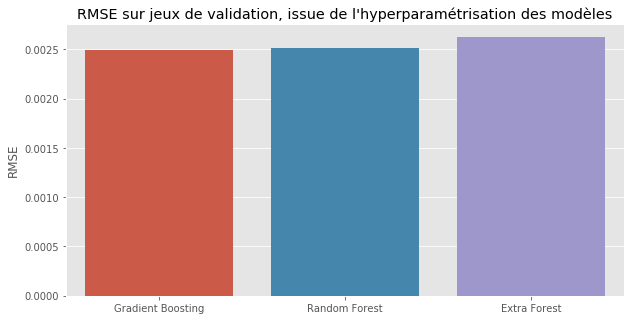

In [83]:
list_type_energy = ["Electricity", "NaturalGas", "SteamUse", "OtherFuelUse"]

# Entrainement de modèles et évaluation sur les données d'entrainement
for energy_type in list_type_energy :
    
    print("______________" + energy_type + "______________")
        
    final_model[energy_type] = SelectBestModel(regressors_2, 
                                               full_pipeline,
                                               param_grid,
                                               train_set,
                                               train_set[energy_type])

### 5.3 Prédiction du CO2

Les prédictions sur les différentes proportions d'énergies remplacent les variables booléennes et la prédiction d'énergie totale est ajouté comme variable numérique.

Dans cette partie nous allons également évaluer la pertinence de l'ENERGYSTARScore, qui est donc ajouté en tant que variable numérique pour la prédiction du Co2

In [84]:
# Liste des variables numériques pour la prédiction du Co2
num_attribs_co2 = num_attribs.copy()
# à laquelle on ajoute les variables énergétiques
num_attribs_co2.extend(list_type_energy)
# Ajout de la prédiction de l'énergie totale aux variables numériques
num_attribs_co2.extend(["SiteEnergyUse(kBtu)"])
# Ajout de l'Energy Star Score dont on va étudier son utilité pour la prédiction du Co2
num_attribs_co2.extend(["ENERGYSTARScore"])

#### 5.3.1 Définitions de pipelines pour le Co2

Pipeline pour le CO2 : ajout des variables prédites et l'Energy Star Score

In [85]:
full_pipeline_co2 = ColumnTransformer([
        ("num", num_pipeline, num_attribs_co2),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [86]:
train_set_Co2 = train_set.copy()
test_set_Co2 = test_set.copy()

Application du pipeline aux données d'entrainement

In [87]:
list_energy_type = ["Electricity",
                    "SteamUse",
                    "NaturalGas",
                    "OtherFuelUse",
                    "SiteEnergyUse(kBtu)"]

In [88]:
for energy_type in list_energy_type :
    preprocessor, regressor = final_model[energy_type]
    train_set_Co2[energy_type] = final_model[energy_type].predict(train_set_Co2)

Application du pipeline aux données test

In [89]:
# On ajoute aux variables d'entrainements les proportions d'énergie prédites
for energy_type in list_energy_type :
    test_set_Co2[energy_type] = final_model[energy_type].predict(test_set_Co2)

In [92]:
len(test_set_Co2.columns)

22

#### 5.3.2 Hyperparamétrisation du modèle séléctionné

Gradient Boosting


C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The

C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The

C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The

Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 150, 'regressor__max_features': 6, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.05, 'preprocess__num__imputer__strategy': 'mean', 'preprocess__cat__imputer__strategy': 'mean'}
r2 score sur tout le jeux d'entrainement:  0.8176492272615097
rmse sur le jeu de validation: 0.8297324308630172


Random Forest


C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The

C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The

Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 100, 'regressor__max_features': 6, 'regressor__max_depth': 10, 'preprocess__num__imputer__strategy': 'mean', 'preprocess__cat__imputer__strategy': 'mean'}
r2 score sur tout le jeux d'entrainement:  0.7984627244805796
rmse sur le jeu de validation: 0.8293383517255271


Extra Forest


C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The

C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The

Hyperparamètres du meilleur modèle : {'regressor__n_estimators': 100, 'regressor__max_features': 8, 'regressor__max_depth': 16, 'preprocess__num__imputer__strategy': 'median', 'preprocess__cat__imputer__strategy': 'mean'}
r2 score sur tout le jeux d'entrainement:  0.9111406986819233
rmse sur le jeu de validation: 0.8295308104780718




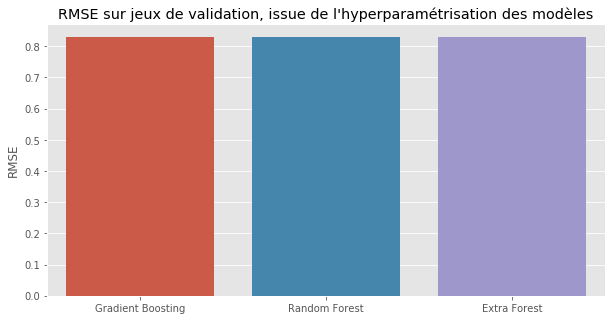

In [93]:
# Selection du meilleur modèle
final_model["TotalGHGEmissions"] = SelectBestModel(regressors_2, 
                                                   full_pipeline_co2,
                                                   param_grid,
                                                   train_set_Co2,
                                                   train_set["TotalGHGEmissions"])

#### 5.3.3 Sauvegarde des modèles

In [87]:
import pickle
# 6 Modèles à sauvegarder : SiteEnergyUse(kBtu), Electricity, NaturalGas, SteamUse, OtherFuelUse, TotalGHGEmissions
for label, model in final_model.items() : 
    # Nom du modèle
    filename = 'final_model' + label + '.sav'
    # Sauvegarde du modèle
    pickle.dump(model, open(filename, 'wb'))

#### 5.3.4 Feature importances

Liste des variables les plus influentes pour la prédiction des émissions de CO2

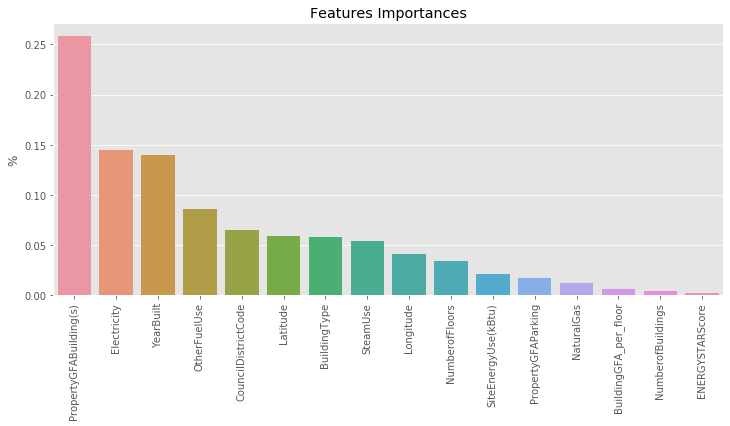

In [88]:
feature_importances = final_model["TotalGHGEmissions"][-1].feature_importances_

# Liste de tous les attributs
extra_attribs = ["BuildingGFA_per_floor"]
attributes = num_attribs_co2 + extra_attribs + cat_attribs

# Les features sont triés par importance pour l'affichage graphique
features = np.array([[feature, attrib] for feature, attrib in sorted(zip(feature_importances, attributes), reverse=True)])
features_labels = [attrib for value, attrib in sorted(zip(feature_importances, attributes), reverse=True)]
features_values = [value for value, attrib in sorted(zip(feature_importances, attributes), reverse=True)]

# Affichage Bar Plot
fig = plt.figure(1, figsize=(12,5))
sns.barplot(x=features_labels[0:20], y=features_values[0:20], orient='v')
plt.ylabel("%")
plt.title("Features Importances")
plt.xticks(rotation=90)
plt.show()

- On retrouve logiquement que les variables relatives à l'énergie apparaissent en haut du classement puisque physiquement les émissions de Co2 en dépendent fortement

- Le label ENERGYSTARScore n'a que très peu d'influence sur le calcul de la prédiction du CO2

## 6. Résultats sur le jeu Test

### 6.1 Prédictions sur les données

In [89]:
# Fonction pour la transformation inverse sur nos variables à prédire
f = lambda x : np.exp(x) - 1
y_test_true = test_set.copy().reset_index()

In [90]:
y_test_pred = pd.DataFrame()

# Resultats sur le jeu Test
print("Resultats sur le jeu Test :", "\n")
for label in ["SiteEnergyUse(kBtu)","TotalGHGEmissions"] :
    print("_______", label, "_______")
    if label == "TotalGHGEmissions" :
        X = test_set_Co2
    else :
        X = test_set
    y_test_pred[label] = final_model[label].predict(X)

    y_true, y_pred = y_test_true[label].apply(f), y_test_pred[label].apply(f)
    
    r2 = final_model[label].score(X, test_set[label]) # r2_score
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # root mean squared error
    mape = mean_absolute_percentage_error(y_true, y_pred) # mean absolute percentage error
    mean_abs_error = mean_absolute_error(y_true, y_pred) # mean absolute error

    
    print("r2 score :", r2)
    print("rmse :", rmse)
    print("mape : {:.2f} %".format(mape))
    print("mean absolute error :", mean_abs_error, "\n")

Resultats sur le jeu Test : 

_______ SiteEnergyUse(kBtu) _______
r2 score : 0.7255008703883905
rmse : 1704789.8837981217
mape : 38.77 %
mean absolute error : 941014.5563530108 

_______ TotalGHGEmissions _______
r2 score : 0.5292773503499464
rmse : 77.19252931920158
mape : 91.52 %
mean absolute error : 38.520634360323854 



### 6.2 Visualisation des erreurs

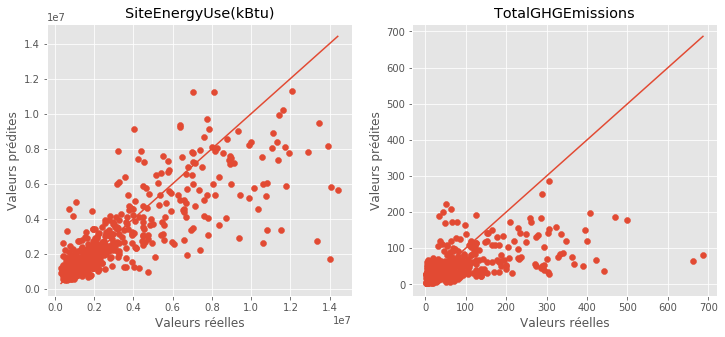

In [91]:
# x : valeurs réelles, y : valeurs prédites
# Graphique 1 : SiteEnergyUse(kBtu)
# Graphique 2 : TotalGHGEmissions
fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]) :
    
    # valeurs test réelles et valeurs test prédites
    y_true, y_pred = y_test_true[label].apply(f), y_test_pred[label].apply(f)

    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.scatter(y_true, y_pred)
    
    # x-min et x-max limites
    x_max = max(y_true.max(), y_pred.max())
    x_min = min(y_true.min(), y_pred.min())
    plt.plot([x_min, x_max] ,[x_min, x_max])
    
plt.show()

- Les données sont en nombre beaucoup plus faible pour les bâtiments à haute consommation d'énergie, ce qui explique les mauvaise prédictions.
- Le modèle pourrait éventuellement se conteter de prédire uniquement les bâtiments dont la consommation d'énergie ne dépasse pas 1e7 à 2e7 kBtu.

C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


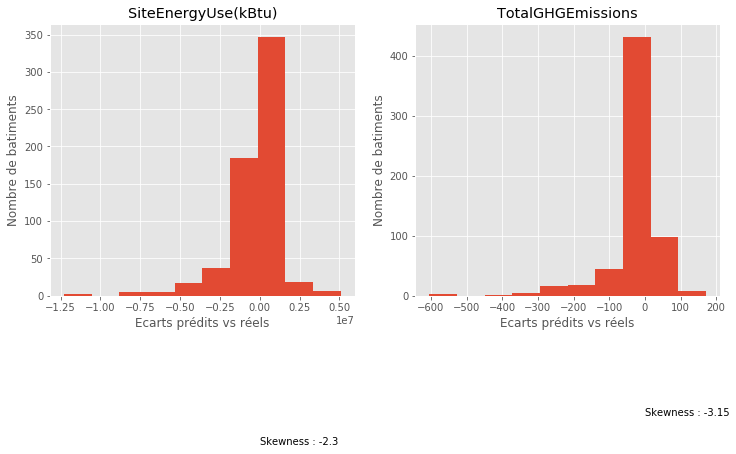

In [92]:
# Histogramme de l'écart entre valeurs prédites et valeurs réelles
# Graphique 1 : SiteEnergyUse(kBtu)
# Graphique 2 : TotalGHGEmissions
fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]) :
    ax = plt.subplot(1,2,i+1)
    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Ecarts prédits vs réels")
    plt.ylabel("Nombre de batiments")
    y = y_test_pred[label].apply(f) - y_test_true[label].apply(f)
    plt.hist(y, bins=int(1 + np.log2(len(test_set))))
    plt.text(0, -200, 'Skewness : ' + str(round(y.skew(),2)))
plt.show()

- L'écart de prédiction est relativement symétrique

### 6.3 Exemples de prédictions de quelques bâtiments

#### Visualisation graphique des erreurs

10 bâtiments sont séléctionnés aléatoirement pour vérifier la qualité du modèle

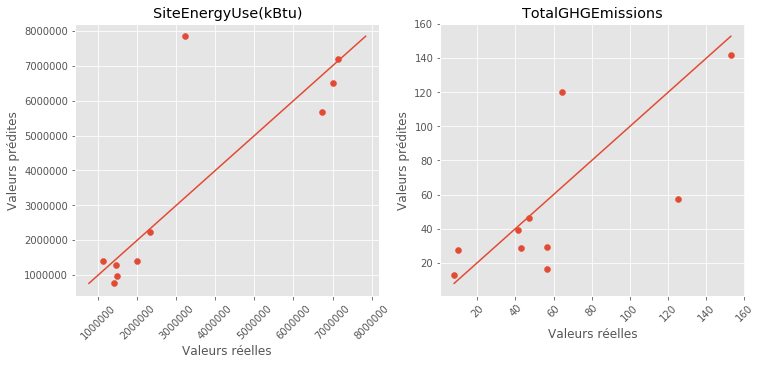

In [93]:
# 10 batiments séléctionnés aléatoirement
nbr_batiments=10
index_bat = np.random.permutation(y_test_true.index)[0:nbr_batiments]

# Séléction des 10 bâtiments
bat_table = y_test_true.loc[index_bat]

fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]) :
    # valeurs test réelles et valeurs test prédites
    y_true, y_pred = y_test_true.loc[index_bat, label].apply(f), y_test_pred.loc[index_bat, label].apply(f)
    
    bat_table[label]  = y_true
    # Calcul de l'écart relatif entre valeurs réelles et valeurs prédites
    bat_table[label + " %"] = 100*abs(y_true - y_pred)/y_true
    
    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.scatter(y_true, y_pred)
    
    x_max = max(y_true.max(), y_pred.max())
    x_min = min(y_true.min(), y_pred.min())
    
    plt.xticks(rotation=45)

    plt.plot([x_min, x_max] ,[x_min, x_max])
plt.show()

#### Calcul de l'écart relatif

In [94]:
# Exemple de 10 bâtiments, écarts relatifs : Energie et CO2
bat_table

,OSEBuildingID,CouncilDistrictCode,PropertyGFAParking,PropertyGFABuilding(s),NumberofFloors,YearBuilt,Longitude,BuildingType,PrimaryPropertyType,Neighborhood,...,ListOfAllPropertyUseTypes,LargestPropertyUseType,ENERGYSTARScore,Electricity,NaturalGas,SteamUse,OtherFuelUse,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu) %,TotalGHGEmissions %
508,481,7.0,73673.0,136143.0,4.0,2006.0,-122.337486,NONRESIDENTIAL,LARGE OFFICE,LAKE UNION,...,"Fitness Center/Health Club/Gym, Office, Parkin...",Office,96.0,0.771443,0.228574,0.0,0.0,7148783.250,0.597471,54.314716
315,26530,4.0,0.0,20600.0,4.0,1919.0,-122.313419,MULTIFAMILY LR (1-4),LOW-RISE MULTIFAMILY,NORTHEAST,...,"Multifamily Housing, Retail Store",Multifamily Housing,NaN,0.276117,0.723888,0.0,0.0,1400340.750,45.691795,71.107290
119,23008,5.0,0.0,32009.0,2.0,1952.0,-122.318644,NONRESIDENTIAL,MIXED USE PROPERTY,NORTH,...,"Non-Refrigerated Warehouse, Office, Retail Store",Non-Refrigerated Warehouse,NaN,0.681019,0.318995,0.0,0.0,1985440.625,29.546050,33.204378
483,289,7.0,0.0,75214.0,3.0,2003.0,-122.365609,SPS-DISTRICT K-12,K-12 SCHOOL,MAGNOLIA / QUEEN ANNE,...,K-12 School,K-12 School,87.5,0.764757,0.235259,0.0,0.0,2315052.500,3.716295,4.375536
85,589,7.0,71385.0,96946.0,4.0,2000.0,-122.331420,NONRESIDENTIAL,LARGE OFFICE,LAKE UNION,...,"Office, Parking",Office,89.5,1.000021,0.000000,0.0,0.0,6738926.750,15.642747,1.363609
266,50024,5.0,92315.0,221280.0,5.0,2014.0,-122.322161,MULTIFAMILY MR (5-9),MID-RISE MULTIFAMILY,NORTH,...,"Multifamily Housing, Parking",Multifamily Housing,90.0,0.678322,0.321692,0.0,0.0,7008169.750,6.989832,7.202913
408,23906,3.0,0.0,21592.0,2.0,1922.0,-122.305922,NONRESIDENTIAL,K-12 SCHOOL,CENTRAL,...,K-12 School,K-12 School,45.0,0.328438,0.671569,0.0,0.0,1488634.500,34.446708,48.494577
514,21836,4.0,8276.5,52950.5,4.0,1989.0,-122.342712,MULTIFAMILY LR (1-4),LOW-RISE MULTIFAMILY,LAKE UNION,...,"Multifamily Housing, Parking",Multifamily Housing,93.5,1.000021,0.000000,0.0,0.0,1134110.375,24.380112,62.966070
513,26139,7.0,0.0,30408.0,3.0,1980.0,-122.342668,NONRESIDENTIAL,OTHER,MAGNOLIA / QUEEN ANNE,...,"Bank Branch, Parking",Bank Branch,60.5,1.000021,0.000000,0.0,0.0,1452705.125,11.589890,168.583002
439,49945,7.0,78000.0,104347.5,3.0,1989.0,-122.342134,NONRESIDENTIAL,SENIOR CARE COMMUNITY,DOWNTOWN,...,"Office, Other - Public Services, Personal Serv...",Senior Care Community,NaN,0.716669,0.283348,0.0,0.0,3209319.750,144.513015,87.013235


- L'écart relatif pour la consommation d'énergie totale et les émissions de Co2 présente quelques erreurs importantes

## 7. Evaluation des performances 

### 7.1 Influence du nombre d'arbres sur la RMSE

In [97]:
x_train_0 = full_pipeline.fit_transform(train_set, train_set["SiteEnergyUse(kBtu)"])
x_test_0 = full_pipeline.transform(test_set)

# On récupère le meilleur modèle déterminé pour la prédiction de l'énergie
gbrt = clone(final_model["SiteEnergyUse(kBtu)"][-1])
gbrt.set_params(n_estimators=500)

gbrt.fit(x_train_0, train_set["SiteEnergyUse(kBtu)"])

# Calcul de la RMSE en fonction du nombre d'arbres
errors = [np.sqrt(mean_squared_error(test_set["SiteEnergyUse(kBtu)"], y_pred))
              for y_pred in gbrt.staged_predict(x_test_0)]
bst_n_estimators = np.argmin(errors) + 1

# Meilleur gradient boosting avec le nombre d'arbres optimal
gbrt_best = gbrt
gbrt_best.set_params(n_estimators=bst_n_estimators)

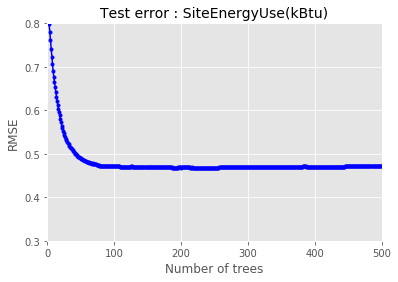

In [98]:
plt.plot(errors, "b.-")
plt.xlabel("Number of trees")
plt.ylabel('RMSE')
plt.axis([0, 500, 0.3, 0.8])
plt.title("Test error : SiteEnergyUse(kBtu)", fontsize=14)
plt.show()

- Le nombre d'arbres de régression n'a plus vraiment d'impacte sur la précision du résultat à partir d'une bonne centaine

### 7.2 Influence  de l'augmentation de la taille du jeu d'entrainement

In [99]:
def plot_learning_curves(model, X_train, X_test, y_train, y_test):
    """
    Graphique de l'évolution de la RMSE en fonction du nombre de données dans le
    jeu d'entrainement
    model(estimator): modèle ML à définir
    X_train(np.array): jeu d'entrainement
    X_test(np.array): jeu de validation
    y_train(np.array): prédiction pour le jeu d'entrainement
    y_train(np.array) : prédiction pour le jeu test
    """
    train_errors, test_errors = [], []
    for m in range(1, len(X_train)):

        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)   
    return test_errors

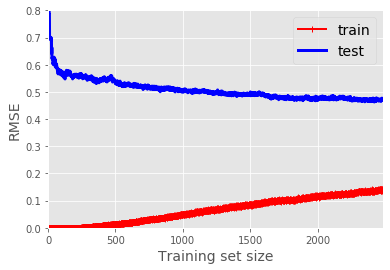

In [100]:
x_train_0 = full_pipeline.fit_transform(train_set, train_set["SiteEnergyUse(kBtu)"])
x_test_0 = full_pipeline.transform(test_set)

gbrt = final_model["SiteEnergyUse(kBtu)"][-1]
gbrt.set_params(n_estimators=500)

training_size_rmse = plot_learning_curves(gbrt,
                            x_train_0,
                            x_test_0,
                            train_set["SiteEnergyUse(kBtu)"],
                            test_set["SiteEnergyUse(kBtu)"])
plt.axis([0, len(x_train_0), 0, 0.8])                         
plt.show()         

L'erreur sur les données d'entrainement est largement inférieur à l'erreur sur le jeux test, ce qui est la marque d'un modèle qui surajuste. Compte tenu de la pente négative de l'erreur sur le jeu test, le meilleur moyen d'améliorer le modèle est d'augmenter la taille du jeu d'entrainement.